# Pets Semantic Segmentation
## <font color=navy>U-Net Convolutional Neural Network + Attention

* Uses U-Net CNN as a backbone
  - Doesn't change contracting (downsampling) step
  - Adds attention mechanism into skip connections in the expanding (upsample) step
  - This allows the network to put more weight on the features of the skip connection that will be relevant
  - **Attention:** highlighting relevant activations during training
    - Reduces computational resources 
    - **Soft** attention suppresses activations in irrelevant regions, reducing redunant features
      - Differentiable and can be trained with backpropagation
* Loosely following (https://keras.io/examples/vision/oxford_pets_image_segmentation/) for architecture and training steps of U-Net, (https://github.com/MoleImg/Attention_UNet/blob/master/AttResUNet.py) for the Attention step
* Sources:
  - https://towardsdatascience.com/a-detailed-explanation-of-the-attention-u-net-b371a5590831
  - https://towardsdatascience.com/using-attention-for-medical-image-segmentation-dd78825eaac6


* Optimization (RMSProp, Adam, Adagrad)
  - https://towardsdatascience.com/optimizers-for-training-neural-network-59450d71caf6
  - https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e
  - https://www.lightly.ai/post/which-optimizer-should-i-use-for-my-machine-learning-project


In [1]:
# For Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/MyDrive/CPE608\ Final\ Project

/content/drive/MyDrive/CPE608 Final Project


In [3]:
import numpy as np
import os
import oxford_pets_generator as op
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.layers import add, Conv2D, BatchNormalization, Activation, SeparableConv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D, Lambda
from tensorflow.keras import Model, models, regularizers
import tensorflow as tf
from sklearn.metrics import classification_report
from tensorflow.keras import backend as K

### Data Handling

In [4]:
# Load data files
train_img = np.load('data/train_img.npy')
train_masks = np.load('data/train_masks.npy')
test_img = np.load('data/test_img.npy')
test_masks = np.load('data/test_masks.npy')
val_img = np.load('data/val_img.npy')
val_masks = np.load('data/val_masks.npy')

X_train = np.load('data/X_train.npy')
y_train = np.load('data/y_train.npy')[:, :, :, 0]
X_test = np.load('data/X_test.npy')
y_test = np.load('data/y_test.npy')[:, :, :, 0]
X_val = np.load('data/X_val.npy')
y_val = np.load('data/y_val.npy')[:, :, :, 0]

# Confirm
print('Number of Training Samples: ', len(train_img))
assert len(train_img) == len(train_masks)
print('Number of Testing Samples: ', len(test_img))
assert len(test_img) == len(test_masks)
print('Number of Validation Samples: ', len(val_img))
assert len(val_img) == len(val_masks)

print()
print(X_train.shape, y_train.shape)

Number of Training Samples:  5908
Number of Testing Samples:  738
Number of Validation Samples:  738

(5908, 160, 160, 3) (5908, 160, 160)


In [6]:
# Define parameters
img_size = (160, 160)
num_classes = 3 # Foreground, background, and ambiguous 
batch_size = 32 # In paper, suggested use 1 image per batch; however, small training data in this case

In [7]:
# Generate data sequences with custom OxfordPets generator
train_data = op.OxfordPets(batch_size, img_size, X_train, y_train)
val_data = op.OxfordPets(batch_size, img_size, X_val, y_val)

### Model Architecture

In [107]:
''' Expansion Function - Repeats elements for dimension compatability '''
# (Guided by: https://github.com/MoleImg/Attention_UNet/blob/master/AttResUNet.py)
def expand(input, num_rep):
     return Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': num_rep})(input)

''' Gate Signal - Activates/Deactivates Attention '''
# (Guided by: https://github.com/MoleImg/Attention_UNet/blob/master/AttResUNet.py)
def gate_signal(input, target_size):
    x = Conv2D(target_size, (1, 1), padding='same')(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

''' Attention Block - Learns target structures of varying shapes and sizes '''
# (Guided by: https://github.com/MoleImg/Attention_UNet/blob/master/AttResUNet.py)
def attention_block(x, gate, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gate)

    theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)
    shape_theta_x = K.int_shape(theta_x)

    phi_g = Conv2D(inter_shape, (1, 1), padding='same')(gate)
    upsample_g = Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)

    concat_xg = add([upsample_g, theta_x])
    act_xg = Activation('relu')(concat_xg)
    psi = Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)

    upsample_psi = expand(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = BatchNormalization()(result)
    return result_bn

''' U-Net CNN with Attention '''
def UNet_CNN_Attention():
  # Define U-Net CNN + Attention Model Architecture
  input = keras.Input(shape = (160, 160, 3, ))

  #### First half of network - downsampling inputs
  # Entry 3x3 convolution
  x = Conv2D(16, 3, strides = 2, padding = 'same')(input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # Record convolution outputs
  convs = [x]

  # Set aside residual
  previous_block_activation = x

  # Convolution blocks: Two 3x3 convolutions followed by 2x2 Max Pooling Operation
  for features in [32, 64, 128, 256]:
    x = SeparableConv2D(features, 3, padding = 'same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = SeparableConv2D(features, 3, padding = 'same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D(3, strides = 2, padding = 'same')(x) # Strides = 2 for downsampling

    # Project residual
    residual = Conv2D(features, 1, strides = 2, padding = 'same')(previous_block_activation)

    # Add back residual
    x = add([x, residual])

    # Record convolution output
    convs.append(x)

    # Set aside next residual
    previous_block_activation = x
    

  # Save projection values for upsampling portion of network 
  prev_block_act = convs[-1]
  prev_block_act_2 = convs[-2]

  #### Second half of network - attention + upsampling inputs 
  for features in [256, 128, 64, 32]:
    # Attention Gate
    gate = gate_signal(prev_block_act, features)
    attention = attention_block(prev_block_act_2, gate, features)
    x = UpSampling2D(2)(prev_block_act)
    x = layers.concatenate([x, attention], axis = 3)

    # Two 3x3 convolutions to half the number of feature channels
    x = Activation('relu')(x)
    x = Conv2DTranspose(features, 3, padding = 'same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = Conv2DTranspose(features, 3, padding = 'same')(x)
    x = BatchNormalization()(x)

    # Upsampling followed by convolution to adjust feature map dimensions
    x = UpSampling2D(2)(x)
    x = Conv2D(features, 2, padding = 'same')(x)

    # Set aside projection values for next iteration
    prev_block_act = prev_block_act_2
    prev_block_act_2 = x

  #### Per-pixel classification layer: 1x1 convolutional layer to map 64-dimensional vector to 3 classes
  output = Conv2D(num_classes, 3, activation = 'softmax', padding = 'same')(x)

  #### Build the model
  model = Model(input, output)

  return model

### Model Training

In [113]:
''' Train model '''
def train_model(train_data, val_data, file_name, optimizer):
  # Instantiate model
  model = UNet_CNN_Attention()

  # Compile model with optimizer and Sparse Categorical Cross Entropy loss
  model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')

  # Define callbacks (ensures model saving)
  callbacks = [keras.callbacks.ModelCheckpoint(file_name, save_best_only=True)]

  # Train the model
  history = model.fit(train_data, epochs = 10, validation_data = val_data, callbacks=callbacks)

  # Plot training vs. validation loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('U-Net CNN with Attention (' + optimizer + '): Training vs. Validation Loss')
  plt.ylabel('Loss (Sparse Categorical Cross-Entropy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

  return model, history

#### <font color = 'navy'> RMSProp

Epoch 1/10
184/184 [==============================] - 62s 294ms/step - loss: 0.7198 - val_loss: 12.2151
Epoch 2/10
184/184 [==============================] - 54s 293ms/step - loss: 0.5365 - val_loss: 4.1177
Epoch 3/10
184/184 [==============================] - 54s 292ms/step - loss: 0.4793 - val_loss: 0.6292
Epoch 4/10
184/184 [==============================] - 54s 292ms/step - loss: 0.4376 - val_loss: 0.4347
Epoch 5/10
184/184 [==============================] - 54s 292ms/step - loss: 0.4044 - val_loss: 0.4230
Epoch 6/10
184/184 [==============================] - 52s 285ms/step - loss: 0.3723 - val_loss: 0.4364
Epoch 7/10
184/184 [==============================] - 54s 292ms/step - loss: 0.3485 - val_loss: 0.4077
Epoch 8/10
184/184 [==============================] - 52s 285ms/step - loss: 0.3286 - val_loss: 0.4572
Epoch 9/10
184/184 [==============================] - 52s 285ms/step - loss: 0.3129 - val_loss: 0.4262
Epoch 10/10
184/184 [==============================] - 53s 286ms/step - 

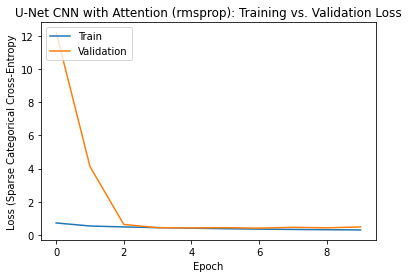

In [114]:
keras.backend.clear_session()
rmsprop_model, rmsprop_history = train_model(train_data, val_data, 'models/cnn_attention_rmsprop.h5', 'rmsprop')

#### <font color = 'navy'> Adam

Epoch 1/10
184/184 [==============================] - 58s 291ms/step - loss: 0.6827 - val_loss: 5.4073
Epoch 2/10
184/184 [==============================] - 53s 290ms/step - loss: 0.5315 - val_loss: 3.7113
Epoch 3/10
184/184 [==============================] - 53s 290ms/step - loss: 0.4809 - val_loss: 1.1711
Epoch 4/10
184/184 [==============================] - 53s 287ms/step - loss: 0.4359 - val_loss: 0.4573
Epoch 5/10
184/184 [==============================] - 51s 278ms/step - loss: 0.4075 - val_loss: 0.4706
Epoch 6/10
184/184 [==============================] - 52s 280ms/step - loss: 0.3802 - val_loss: 0.4658
Epoch 7/10
184/184 [==============================] - 53s 290ms/step - loss: 0.3546 - val_loss: 0.4199
Epoch 8/10
184/184 [==============================] - 52s 283ms/step - loss: 0.3357 - val_loss: 0.4640
Epoch 9/10
184/184 [==============================] - 52s 282ms/step - loss: 0.3221 - val_loss: 0.4364
Epoch 10/10
184/184 [==============================] - 52s 281ms/step - l

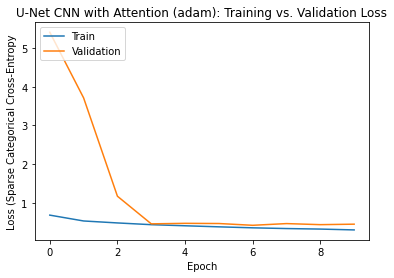

In [115]:
keras.backend.clear_session()
adam_model, adam_history = train_model(train_data, val_data, 'models/cnn_attention_adam.h5', 'adam')

#### <font color = 'navy'> Adagrad

Epoch 1/10
184/184 [==============================] - 55s 275ms/step - loss: 0.9861 - val_loss: 1.1370
Epoch 2/10
184/184 [==============================] - 50s 273ms/step - loss: 0.8084 - val_loss: 1.1961
Epoch 3/10
184/184 [==============================] - 52s 284ms/step - loss: 0.7547 - val_loss: 1.0056
Epoch 4/10
184/184 [==============================] - 53s 286ms/step - loss: 0.7248 - val_loss: 0.6989
Epoch 5/10
184/184 [==============================] - 53s 288ms/step - loss: 0.7031 - val_loss: 0.6838
Epoch 6/10
184/184 [==============================] - 53s 287ms/step - loss: 0.6864 - val_loss: 0.6755
Epoch 7/10
184/184 [==============================] - 53s 288ms/step - loss: 0.6723 - val_loss: 0.6663
Epoch 8/10
184/184 [==============================] - 53s 289ms/step - loss: 0.6602 - val_loss: 0.6570
Epoch 9/10
184/184 [==============================] - 53s 288ms/step - loss: 0.6507 - val_loss: 0.6455
Epoch 10/10
184/184 [==============================] - 52s 281ms/step - l

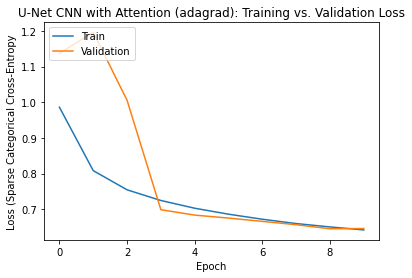

In [116]:
keras.backend.clear_session()
adagrad_model, adagrad_history = train_model(train_data, val_data, 'models/cnn_attention_adagrad.h5', 'adagrad')

### Evaluation

In [6]:
''' Get prediction vectors '''
def get_predictions(model):
  # Get predictions as probability vector, then discrete vector (add 1 to account for index)
  train_pred = model.predict(X_train)
  train_pred_vec = np.argmax(train_pred, axis=-1) + 1

  val_pred = model.predict(X_val)
  val_pred_vec = np.argmax(val_pred, axis=-1) + 1

  test_pred = model.predict(X_test)
  test_pred_vec = np.argmax(test_pred, axis=-1) + 1

  return train_pred_vec, val_pred_vec, test_pred_vec

In [7]:
# RMSProp
rms_train, rms_val, rms_test = get_predictions(rmsprop_model)

In [8]:
# Adam
adam_train, adam_val, adam_test = get_predictions(adam_model)

In [7]:
# Adagrad
adagrad_train, adagrad_val, adagrad_test = get_predictions(adagrad_model)

In [8]:
# Write to files
np.save('data/preds/att_rmsprop_train.npy', rms_train)
np.save('data/preds/att_rmsprop_val.npy', rms_val)
np.save('data/preds/att_rmsprop_test.npy', rms_test)

np.save('data/preds/att_adam_train.npy', adam_train)
np.save('data/preds/att_adam_val.npy', adam_val)
np.save('data/preds/att_adam_test.npy', adam_test)

np.save('data/preds/att_adagrad_train.npy', adagrad_train)
np.save('data/preds/att_adagrad_val.npy', adagrad_val)
np.save('data/preds/att_adagrad_test.npy', adagrad_test)